In [ ]:
import pathlib
import numpy as np
from scipy import sparse
import pandas as pd
from sklearn.model_selection import KFold
from scipy.stats import pearsonr
from nilearn import plotting, maskers
from neuroquery import datasets
from neuroquery.img_utils import coordinates_to_maps
from neuroquery.smoothed_regression import SmoothedRegression
from neuroquery.tokenization import TextVectorizer
from neuroquery.encoding import NeuroQueryModel

from sklearn.model_selection import KFold
from neurovlm.loss import compute_metrics
from tqdm.notebook import tqdm

import sys
# sys.path.append('/home/jerjes/repos/neurovlm/src/neurovlm')
sys.path.append('/Users/ryanhammonds/projects/neurovlm')

import torch
from neurovlm.models import TextAligner
from neurovlm.train import Trainer

from neurovlm.data import get_data_dir
import nibabel as nib
import numpy as np

# Neuroquery

In [2]:
# Load NeuroQuery data
data_dir = pathlib.Path(datasets.fetch_neuroquery_model())
corpus_metadata = pd.read_csv(str(data_dir / "corpus_metadata.csv"))
vectorizer = TextVectorizer.from_vocabulary_file(str(data_dir / "vocabulary.csv"))
tfidf = sparse.load_npz(str(data_dir / "corpus_tfidf.npz"))
coordinates = pd.read_csv(datasets.fetch_peak_coordinates())
print(f"Loaded {corpus_metadata.shape[0]} studies")

Loaded 13459 studies


In [ ]:
# # coords to brain maps
# brain_maps, masker = coordinates_to_maps(
#     coordinates, target_affine=(6, 6, 6), fwhm=9.0
# )
# brain_maps = brain_maps[(brain_maps.values != 0).any(axis=1)]

# # Align TFIDF and brain maps (exactly like their notebook)
# pmids = brain_maps.index.intersection(corpus_metadata["pmid"])
# rindex = pd.Series(np.arange(corpus_metadata.shape[0]), index=corpus_metadata["pmid"])
# tfidf_final = tfidf.toarray()[rindex.loc[pmids].values, :]
# brain_maps_final = brain_maps.loc[pmids, :].values

# print(f"Final dataset: {len(pmids)} studies")
# print(f"TFIDF shape: {tfidf_final.shape}")
# print(f"Brain maps shape: {brain_maps_final.shape}")

# These were pre-computed from the neurocontext pmid set
neurovlm_data_dir = pathlib.Path(get_data_dir())

mask_img = nib.load(neurovlm_data_dir / "neuroquery_masker.nii.gz")
brain_maps = pd.DataFrame(np.load(neurovlm_data_dir / "brain_maps.npy"))
pmids_neurocontext = np.load(neurovlm_data_dir / "pmids_neurocontext.npy")

brain_maps.index = pmids_neurocontext
masker = maskers.NiftiMasker(mask_img)
masker.fit()

In [4]:
# Align TFIDF and brain maps (exactly like their notebook)
pmids = brain_maps.index.intersection(corpus_metadata["pmid"])
rindex = pd.Series(np.arange(corpus_metadata.shape[0]), index=corpus_metadata["pmid"])
tfidf_final = tfidf.toarray()[rindex.loc[pmids].values, :]
brain_maps_final = brain_maps.loc[pmids, :].values
# brain_maps.to_csv('neuroquery_brain_maps.csv')

# filer out neurcontext specific ids
brain_maps = brain_maps[brain_maps.index.isin(pmids)]

In [5]:
from neurovlm.data import get_data_dir

neurovlm_dir = get_data_dir()
publications_df = pd.read_parquet(neurovlm_dir / "publications_more.parquet")

print(f"NeuroQuery corpus: {corpus_metadata.shape[0]} studies")
print(f"NeuroVLM publications: {publications_df.shape[0]} studies")

# Find common PMIDs
nq_pmids = set(corpus_metadata['pmid'])
your_pmids = set(publications_df['pmid'])
common_pmids = nq_pmids & your_pmids
print(f"Common PMIDs: {len(common_pmids)} studies")

NeuroQuery corpus: 13459 studies
NeuroVLM publications: 30826 studies
Common PMIDs: 13459 studies


In [ ]:
publications_matched = publications_df[publications_df['pmid'].isin(pmids)].copy()
publications_matched = publications_matched.set_index('pmid').loc[pmids].reset_index()

# Create query text
def create_query_text(row):
    name = str(row['name']) if pd.notna(row['name']) else ""
    description = str(row['description']) if pd.notna(row['description']) else ""
    if name and description:
        return f"{name} [SEP] {description}"
    elif name:
        return name
    else:
        return "brain activation study"

publications_matched['query_text'] = publications_matched.apply(create_query_text, axis=1)

corpus_metadata.rename(columns={"index": "pmid"}, inplace=True)
corpus_metadata = corpus_metadata.set_index("pmid").reset_index()

In [9]:
kf = KFold(n_splits=10, shuffle=True, random_state=0)

for train_inds, test_inds in kf.split(list(np.arange(len(brain_maps_final)))):

    regressor = SmoothedRegression(alphas=np.array([1.0, 10.0, 100.0]))
    print("Fitting smoothed regression model on {} samples...".format(tfidf.shape[0]))
    _ = regressor.fit(tfidf_final[train_inds], brain_maps_final[train_inds])

    encoder = NeuroQueryModel(
        vectorizer,
        regressor,
        mask_img,
        corpus_info={
            "tfidf": sparse.csr_matrix(tfidf),
            "metadata": corpus_metadata,
        },
    )

    # Metrics
    r = np.zeros(len(test_inds))
    mse = np.zeros((len(test_inds), 3))
    ssim = np.zeros((len(test_inds), 3))
    dice = np.zeros((len(test_inds), 3))

    for i in tqdm(range(len(test_inds)), total=len(test_inds)):
        img_pred = encoder(publications_matched.iloc[test_inds[i]]["query_text"])["brain_map"]
        vec_pred = masker.transform(img_pred)
        vec_true = brain_maps_final[test_inds[i]:test_inds[i]+1]

        mse[i], ssim[i], dice[i] = compute_metrics(vec_true, vec_pred)
        r[i] = np.corrcoef(vec_true, vec_pred)[0][1]

    break

Fitting smoothed regression model on 13459 samples...
keeping 232 features


  0%|          | 0/1346 [00:00<?, ?it/s]

/Users/ryanhammonds/projects/neurovlm/back_gh/neurovlm/.env/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/ryanhammonds/projects/neurovlm/back_gh/neurovlm/.env/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/ryanhammonds/projects/neurovlm/back_gh/neurovlm/.env/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/ryanhammonds/projects/neurovlm/back_gh/neurovlm/.env/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/ryanhammonds/projects/neurovlm/back_gh/neurovlm/.env/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/ryanhamm

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

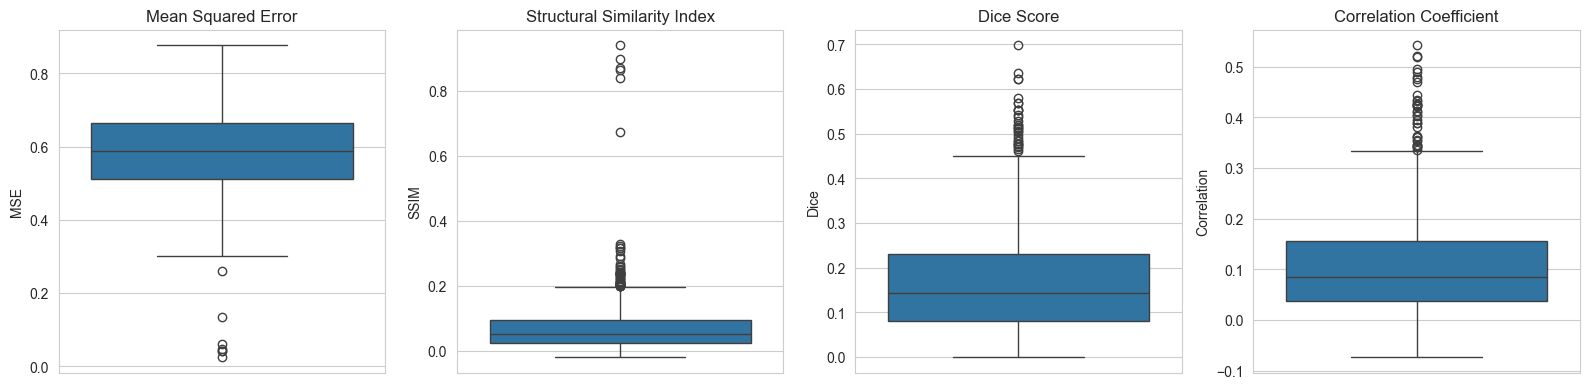

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

sns.boxplot(mse[:, 0], ax=axes[0])
sns.boxplot(ssim[:, 0], ax=axes[1])
sns.boxplot(dice[:, 0], ax=axes[2])
sns.boxplot(r, ax=axes[3])

axes[0].set_title('Mean Squared Error')
axes[0].set_ylabel('MSE')
axes[1].set_title('Structural Similarity Index')
axes[1].set_ylabel('SSIM')
axes[2].set_title('Dice Score')
axes[2].set_ylabel('Dice')
axes[3].set_title('Correlation Coefficient')
axes[3].set_ylabel('Correlation')
plt.tight_layout()
plt.savefig("/Users/ryanhammonds/Desktop/neuroquery_decoding.png")